# Predicting Chronic Kidney Disease based on health records
Given 24 health related attributes taken in 2-month period of 400 patients, using the information of the 158 patients with complete records to predict the outcome (i.e. whether one has chronic kidney disease) of the remaining 242 patients (with missing values in their records).



## Load Modules and helper functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
%matplotlib inline

def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

## Load files

In [3]:
df = pd.read_csv("C:/Users/Sinegalatha/Desktop/2nd year online class/nalaiya thiran/dataset/kidney_disease.csv")

In [4]:
df.head()


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [5]:
df['wc']

0      7800
1      6000
2      7500
3      6700
4      7300
       ... 
395    6700
396    7800
397    6600
398    7200
399    6800
Name: wc, Length: 400, dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [7]:
df.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [8]:
df[df.duplicated()]

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification


## Cleaning and preprocessing of data for training a classifier

In [9]:
# Map text to 1/0 and do some cleaning
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

In [10]:
# Further cleaning
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
df.drop('id',axis=1,inplace=True)

In [11]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Check the portion of rows with NaN
- Now the data is cleaned with improper values labelled NaN. Let's see how many NaNs are there.
- Drop all the rows with NaN values, and build a model out of this dataset (i.e. df2)

In [12]:
df2 = df.dropna(axis=0)
df2['class'].value_counts()

0.0    115
1.0     43
Name: class, dtype: int64

## Examine correlations between different features

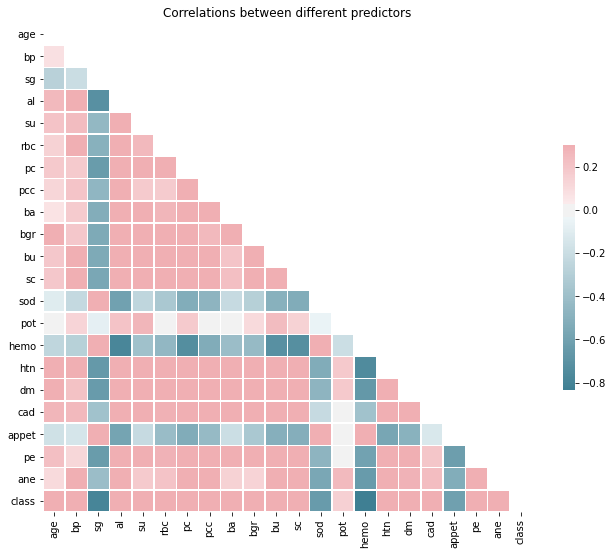

In [13]:
corr_df = df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

## Split the set for training models further into a (sub-)training set and testing set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['class'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= df2['class'] )


In [34]:
X_train.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
317,58.0,70.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,102.0,...,15.0,40,8100,4.9,0.0,0.0,0.0,1.0,0.0,0.0
296,41.0,70.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,125.0,...,16.8,41,6300,5.9,0.0,0.0,0.0,1.0,0.0,0.0
157,62.0,70.0,1.025,3.0,0.0,0.0,1.0,0.0,0.0,122.0,...,12.6,39,7900,3.9,1.0,1.0,0.0,1.0,0.0,0.0
258,42.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,98.0,...,13.9,44,8400,5.5,0.0,0.0,0.0,1.0,0.0,0.0
291,47.0,80.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,124.0,...,14.9,41,7000,5.7,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
print(X_train.shape)
print(X_test.shape)

(105, 24)
(53, 24)


In [16]:
y_train.value_counts()

0.0    76
1.0    29
Name: class, dtype: int64

## Choosing parameters with GridSearchCV with 10-fold cross validations.
(Suggestion for next time: try using Bayesian model selection method)

Detailed classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        39
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Confusion Matrix:
[[39  0]
 [ 0 14]]


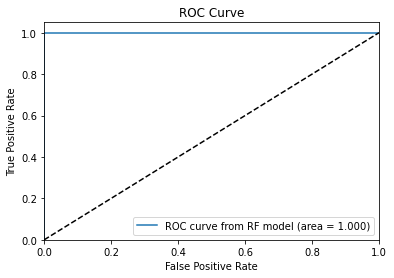

Best parameters:
{'class_weight': None, 'max_depth': 2, 'n_estimators': 8, 'random_state': 42}


In [17]:
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
clf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_


## Examine feature importance
Since I pruned the forest (*max_depth*=2) and decrease the number of trees (*n_estimators*=8), not all features are used.

Text(0.5, 1.0, 'Feature Importance')

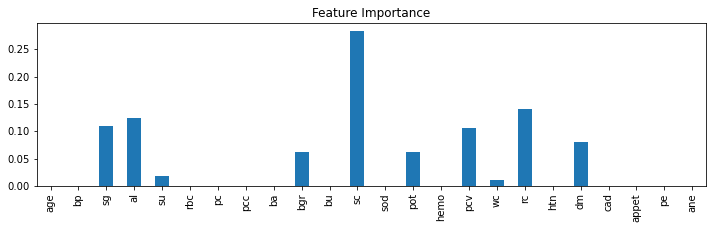

In [18]:
plt.figure(figsize=(12,3))
features = X_test.columns.values.tolist()
importance = clf_best.feature_importances_.tolist()
feature_series = pd.Series(data=importance,index=features)
feature_series.plot.bar()
plt.title('Feature Importance')

In [19]:
list_to_fill = X_test.columns[feature_series>0]
print(list_to_fill)

Index(['sg', 'al', 'su', 'bgr', 'sc', 'pot', 'pcv', 'wc', 'rc', 'dm'], dtype='object')


## Next, I examine the rest of the dataset (with missing values across the rows)
Are there correlations between occurence of missing values in a row? The plot suggests, seems no.

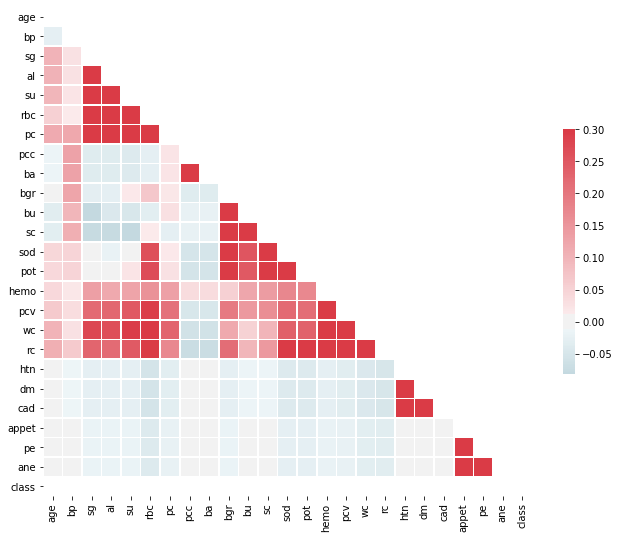

In [20]:
# Are there correlation in missing values?
corr_df = pd.isnull(df).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Make predictions with the best model selected above
I filled in all NaN with 0 and pass it to the trained classifier. The results are as follows:
- True positive = 180
- True negative = 35
- False positive = 0
- False negative = 27
----
- Accuracy = 88.8%
- ROC AUC = 99.2%

              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72        35
         1.0       1.00      0.87      0.93       207

    accuracy                           0.89       242
   macro avg       0.78      0.93      0.83       242
weighted avg       0.94      0.89      0.90       242

Confusion Matrix:
[[ 35   0]
 [ 27 180]]
Accuracy: 0.888430


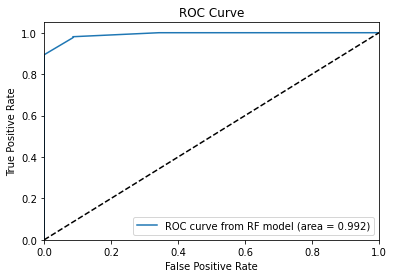

In [21]:
df2 = df.dropna(axis=0)
no_na = df2.index.tolist()
some_na = df.drop(no_na).apply(lambda x: pd.to_numeric(x,errors='coerce'))
some_na = some_na.fillna(0) # Fill up all Nan by zero.

X_test = some_na.iloc[:,:-1]
y_test = some_na['class']
y_true = y_test
lr_pred = clf_best.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_best, X_test, y_test, 'RF')
 


In [23]:
import pickle
pickle. dump(clf_best, open('randomclass_chronic', 'wb'))

## Summary of Results
With proper tuning of parameters using cross-validation in the training set, the Random Forest Classfier achieves an accuracy of 88.8% and an ROC AUC of 99.2%. Lesson learnt: It happens that some pruning helps improve the performance of RF a lot.[](http://)